# *Capstone Project - Toronto Neighborhoods*
## Week 1 - Introduction
The aim is to find the best neighborhood in Toronto where to move

In [1]:
import pandas as pd
import numpy as np

In [2]:
print('Hello capstone project course!')

Hello capstone project course!


## Week 2 - Data Collection
### 1 - Data Scraping

In [3]:
from bs4 import BeautifulSoup
import requests

In [4]:
import urllib3
urllib3.disable_warnings()

Create s Soup Object

In [5]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
data  = requests.get(url,verify=False).text
soup = BeautifulSoup(data, 'html5lib')

Find the table with Neighborhoods information

In [6]:
tables = soup.find_all('table')

In [7]:
for index,table in enumerate(tables):
    if ("M3A" in str(table)):
        table_index = index

table_index

0

Visualize the _html_ structure of the table 

In [8]:
#print(tables[table_index].prettify())

Create the dictionary with keys Postal code, borough and neighborhood. Then find in the table every neighborhood and append each row to create the complete dictionary.

In [9]:
Toronto_PC = pd.DataFrame(columns=["Postal Code", "Borough", "Neighborhood"])

for row in tables[table_index].tbody.find_all("td"):
    if row.span.text=='Not assigned':
        pass
    else:
        PostalCode = row.p.text[:3]
        Borough = (row.span.text).split('(')[0]
        Neighborhood = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        Toronto_PC = Toronto_PC.append({"Postal Code": PostalCode, "Borough":Borough, "Neighborhood":Neighborhood}, ignore_index=True)
        

Create Pandas dataframe from dictionary

In [10]:
df=pd.DataFrame(Toronto_PC)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

In [11]:
df.shape

(103, 3)

### 2 - Data Completion
Assign Geo Coordinates to each neighborhood

In [12]:
#import geocoder # import geocoder

#def assign_latlon(PC):
# loop until you get the coordinates
#    lat_lng_coords = None
#    while(lat_lng_coords is None):
#        g = geocoder.google('{}, Toronto, Ontario'.format(PC))
#        lat_lng_coords = g.latlng
#        latitude = lat_lng_coords[0]
#        longitude = lat_lng_coords[1]
#    return latitude, longitude
    

In [13]:
#v_assign_latlon = np.vectorize(assign_latlon)

In [14]:
#*df['Latitude','Longitude'] = v_assign_latlon(df['Postal Code'])

Import data in csv since geocoder does not work

In [15]:
import os, types
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.

if os.environ.get('RUNTIME_ENV_LOCATION_TYPE') == 'external':
    endpoint_1a4a7592427d42e1b61840053f7aeeea = 'https://s3.eu-geo.objectstorage.softlayer.net'
else:
    endpoint_1a4a7592427d42e1b61840053f7aeeea = 'https://s3.eu-geo.objectstorage.service.networklayer.com'

client_1a4a7592427d42e1b61840053f7aeeea = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='MUf9M4bDOqSLJyqiQYrTVCxGvKl_G5aC793SlNe18khU',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url=endpoint_1a4a7592427d42e1b61840053f7aeeea)

body = client_1a4a7592427d42e1b61840053f7aeeea.get_object(Bucket='prova-donotdelete-pr-nn8iojtt4olpmz',Key='Geospatial_Coordinates.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_1 = pd.read_csv(body)
df1 = df

Final Dataframe wit geo coordinates

In [16]:
df = pd.merge(df1, df_data_1, on='Postal Code',how='inner')
df.head(5)

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


In [17]:
#!conda install -c conda-forge folium=0.5.0 --yes 

from geopy.geocoders import Nominatim
import folium

In [18]:
address = 'Toronto, Canada'

geolocator = Nominatim(user_agent="To_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [19]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)

for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

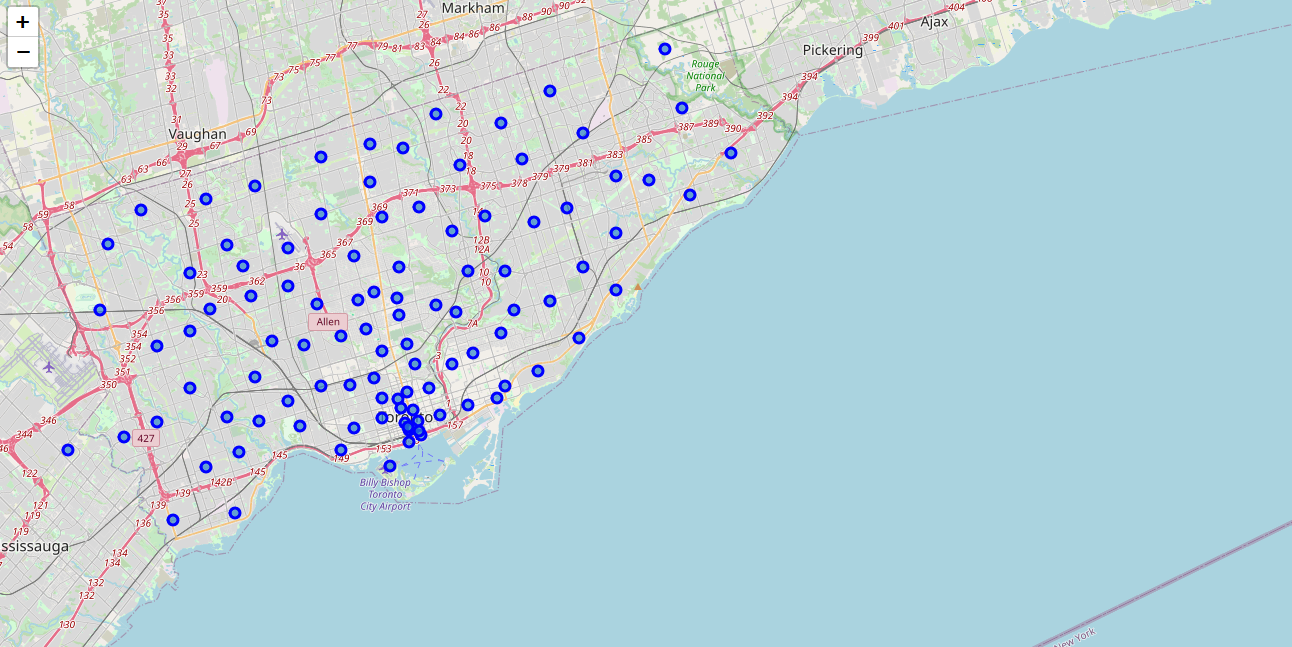

### 3 - Clustering

Input the data for foursquare requests

In [20]:
CLIENT_ID = '15BVIWVORNZATBPR2UDHW2XHE0DS2B24KARGUWJ5JQDBCJ0X' # your Foursquare ID
CLIENT_SECRET = 'ZWUORIZXBPY4PPZ2QQUPLRYCQQXDSJWVHTS0TEJOIZHJBA35' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 15BVIWVORNZATBPR2UDHW2XHE0DS2B24KARGUWJ5JQDBCJ0X
CLIENT_SECRET:ZWUORIZXBPY4PPZ2QQUPLRYCQQXDSJWVHTS0TEJOIZHJBA35


GET request URL creation

In [21]:
neighborhood_latitude = df.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = df.loc[0, 'Neighborhood'] # neighborhood name



LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 500 # define radius

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=15BVIWVORNZATBPR2UDHW2XHE0DS2B24KARGUWJ5JQDBCJ0X&client_secret=ZWUORIZXBPY4PPZ2QQUPLRYCQQXDSJWVHTS0TEJOIZHJBA35&v=20180605&ll=43.7532586,-79.3296565&radius=500&limit=100'

Define a function that extracts the category of the venue

In [22]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Create a dataframe from json

In [23]:
results = requests.get(url).json()
results

venues = results['response']['groups'][0]['items']
    
nearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Brookbanks Park,Park,43.751976,-79.332140
1,TTC stop #8380,Bus Stop,43.752672,-79.326351
2,Variety Store,Food & Drink Shop,43.751974,-79.333114


In [24]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [25]:
Toronto_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Ontario Provincial Government
Islington Avenue
Malvern, Rouge
Don Mills North
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills South
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
The Danforth  East
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmount Park
Bayview Village
Downsview East
The Danforth

In [26]:
# one hot encoding
Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Toronto_onehot['Neighborhood'] = Toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Toronto_onehot.columns[-1]] + list(Toronto_onehot.columns[:-1])
Toronto_onehot = Toronto_onehot[fixed_columns]

Toronto_onehot.head()

,Yoga Studio,Accessories Store,Adult Boutique,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Visualize venues of each neighborhood

In [27]:
Toronto_grouped = Toronto_onehot.groupby('Neighborhood').mean().reset_index()

In [28]:
df.drop([5,11,45,52,95],inplace=True)

In [29]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Create a new dataframe with top 10 common venue for each neighborhood

In [30]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Toronto_grouped['Neighborhood']

for ind in np.arange(Toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Lounge,Breakfast Spot,Latin American Restaurant,Skating Rink,Metro Station,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop,Middle Eastern Restaurant,Mexican Restaurant
1,"Alderwood, Long Branch",Pizza Place,Coffee Shop,Gym,Sandwich Place,Skating Rink,Pub,Mexican Restaurant,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop
2,"Bathurst Manor, Wilson Heights, Downsview North",Bank,Coffee Shop,Restaurant,Ice Cream Shop,Supermarket,Fried Chicken Joint,Chinese Restaurant,Bridal Shop,Gas Station,Diner
3,Bayview Village,Café,Japanese Restaurant,Bank,Chinese Restaurant,Yoga Studio,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop
4,"Bedford Park, Lawrence Manor East",Italian Restaurant,Hobby Shop,Coffee Shop,Sandwich Place,Breakfast Spot,Juice Bar,Sushi Restaurant,Japanese Restaurant,Liquor Store,Pub


Clustering using k-means

In [31]:
from sklearn.cluster import KMeans
# set number of clusters
kclusters = 10

Toronto_grouped_clustering = Toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=1).fit(Toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 
if len(neighborhoods_venues_sorted.columns)==12:
    neighborhoods_venues_sorted.drop(['Cluster Labels'],1,inplace=True)


neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [32]:
Toronto_merged = df

Toronto_merged = Toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
Toronto_merged['Cluster Labels'].astype(np.int64)

Toronto_merged.head(6) # check the last columns!

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,0,Food & Drink Shop,Bus Stop,Park,Metro Station,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop,Middle Eastern Restaurant,Mexican Restaurant,Yoga Studio
1,M4A,North York,Victoria Village,43.725882,-79.315572,4,Pizza Place,Hockey Arena,Intersection,Coffee Shop,Portuguese Restaurant,Men's Store,Metro Station,Mediterranean Restaurant,Medical Center,Massage Studio
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,2,Coffee Shop,Park,Café,Bakery,Pub,Breakfast Spot,Theater,Cosmetics Shop,Dessert Shop,Beer Store
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,2,Clothing Store,Furniture / Home Store,Boutique,Arts & Crafts Store,Miscellaneous Shop,Gift Shop,Coffee Shop,Vietnamese Restaurant,Accessories Store,Mediterranean Restaurant
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494,2,Coffee Shop,Sushi Restaurant,Sandwich Place,Beer Bar,Fried Chicken Joint,Smoothie Shop,Burrito Place,Mexican Restaurant,Café,Yoga Studio
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,8,Fast Food Restaurant,Metro Station,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop,Middle Eastern Restaurant,Mexican Restaurant,Yoga Studio,Monument / Landmark


Visualize the map with clustered neigborhoods

In [33]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_merged['Latitude'], Toronto_merged['Longitude'], Toronto_merged['Neighborhood'], Toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

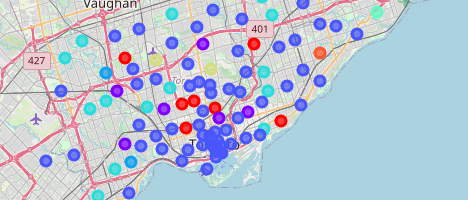